# PCA and Clustering Analysis of Drug Sensitivity Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Data Preparation

* Clean the dataset by handling missing values
* Scale/normalize the data
* Check for outliers
* Separate metadata from drug sensitivity values

In [2]:
data = pd.read_csv('test_data/pca_clustering/BRCA_Drug_sensitivity_test_data.csv')
data.head()

,Patient ID,bendamustine,ML320,BRD-K14844214,leptomycin B,Compound 23 citrate,BRD4132,dabrafenib,necrosulfonamide,PF-543,...,Compound 1541A,pevonedistat,ISOX,tosedostat,AT13387,BRD-A02303741,BRD-K99006945,GSK525762A,necrostatin-7,nakiterpiosin
0,TCGA-D8-A1JU,14.821152,14.286200,14.608184,4.960653,13.530885,13.202820,13.879099,12.839373,14.103941,...,14.778758,12.541663,12.113460,12.364817,8.913646,14.860838,13.170200,13.116395,14.548597,11.835573
1,TCGA-AC-A3QQ,14.304843,14.333355,14.960661,3.552977,13.122806,13.129905,13.911525,12.124210,14.127482,...,15.108698,10.936052,11.802052,11.893495,8.326862,15.265313,15.341146,13.509974,14.311074,10.772699
2,TCGA-C8-A12Q,14.658052,14.649223,14.547810,3.467945,13.438683,13.441228,13.823993,12.935296,14.052508,...,15.012134,12.837987,11.944058,11.694113,8.622052,15.205567,14.039701,13.252381,14.496764,11.387851
3,TCGA-AR-A1AY,14.342911,13.657840,14.426898,1.800027,13.242654,13.094447,13.531232,11.987928,14.046877,...,14.811534,11.098317,11.480102,11.379716,8.080488,14.906361,13.462326,13.030773,14.466555,9.665608
4,TCGA-A8-A0A2,14.655920,14.323148,14.527811,4.491210,13.293485,13.054068,13.807173,12.446720,14.012040,...,14.816099,12.075367,11.878005,11.800027,8.595326,14.988143,14.074985,12.959710,14.435152,11.143563


In [3]:
print(f"Dataset shape: {data.shape}")
print(f"Patient IDs: {data['Patient ID'].nunique()} unique values")
print(f"Features: {data.shape[1]-1} drug sensitivity measurements")

Dataset shape: (25, 51)
Patient IDs: 25 unique values
Features: 50 drug sensitivity measurements


**Notes: High-dimensional data**

* High-dimensional data refers to datasets where the number of features or attributes (dimensions, denoted as p) is significantly large
* In such datasets, each observation can be thought of as residing in a high-dimensional space
* The definition of “high-dimensional” data can vary depending on the context, the field of study, and the specific analysis being performed. 

***Dataset with 51 columns (drug compounds) and 25 rows (patients):***

* Contains more features (50 drug sensitivity scores) than samples (25 patients)
* *Difficulty in Visualization:* Identifying patterns visually becomes impossible
* *Sparsity:* With 50 features but only 25 samples, data points are scattered across a vast 50-dimensional space
* *Distance metrics become less meaningful:* In high dimensions, the difference between the nearest and farthest neighbors becomes less significant - nearly all points appear similar-distances from each other
* *Overfitting risk:* model has many potential combinations of features to consider, but limited examples to learn from, it has a large capacity to fit even noise in the limited training examples leading to overfitting and poor performance



### Clean the dataset by handling missing values

In [4]:
# Check for missing values
data.isnull().sum().sum()

np.int64(0)

In [5]:
# Check data types
print("\nData types:")
print("Datatypes of first 10 columns:", data.dtypes[:10])
print("Different datatypes in the dataframe:", data.dtypes.unique())



Data types:
Datatypes of first 10 columns: Patient ID              object
bendamustine           float64
ML320                  float64
BRD-K14844214          float64
leptomycin B           float64
Compound 23 citrate    float64
BRD4132                float64
dabrafenib             float64
necrosulfonamide       float64
PF-543                 float64
dtype: object
Different datatypes in the dataframe: [dtype('O') dtype('float64')]


In [6]:
# Basic statistics for drug sensitivity values
data.iloc[2:,:].describe().T.sort_values('mean', ascending=False).head(10)

,count,mean,std,min,25%,50%,75%,max
myricetin,23.0,15.127781,0.043648,15.053067,15.096893,15.120994,15.155024,15.219127
BRD-A02303741,23.0,15.058320,0.159268,14.703860,14.972472,15.036734,15.189483,15.398952
Compound 1541A,23.0,14.904553,0.133135,14.724434,14.813816,14.879828,14.980993,15.318321
carboplatin,23.0,14.702336,0.125446,14.459443,14.616819,14.671899,14.792503,14.915819
BRD-K27188169,23.0,14.617804,0.081542,14.428273,14.590463,14.623367,14.677617,14.733081
BRD-K14844214,23.0,14.595832,0.147466,14.393664,14.508334,14.556776,14.667987,15.019018
pifithrin-mu,23.0,14.591323,0.279634,14.076076,14.368822,14.613301,14.806519,15.095189
RO4929097,23.0,14.572361,0.183090,13.979993,14.501869,14.601869,14.672865,14.924847
RG-108,23.0,14.452341,0.227177,13.957360,14.273068,14.487281,14.601165,14.816620
necrostatin-7,23.0,14.445742,0.095685,14.243220,14.373044,14.437777,14.508483,14.623232


In [7]:
# Step 2: Exploratory Data Analysis
def perform_eda(data):
    print("\n=== Exploratory Data Analysis ===")
    # Separate metadata from drug sensitivity values
    drug_data = data.drop('Patient ID', axis=1)
    
    # Distribution of drug sensitivity values
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(drug_data.values.flatten(), kde=True)
    plt.title('Distribution of Drug Sensitivity Values')
    plt.xlabel('Sensitivity Value')
    
    # Boxplot of drug sensitivity values (first 10 drugs)
    plt.subplot(1, 2, 2)
    sns.boxplot(data=drug_data.iloc[:, :10])
    plt.title('Boxplot of First 10 Drugs')
    plt.xticks(rotation=90)
    plt.tight_layout()

    return drug_data
 


=== Exploratory Data Analysis ===


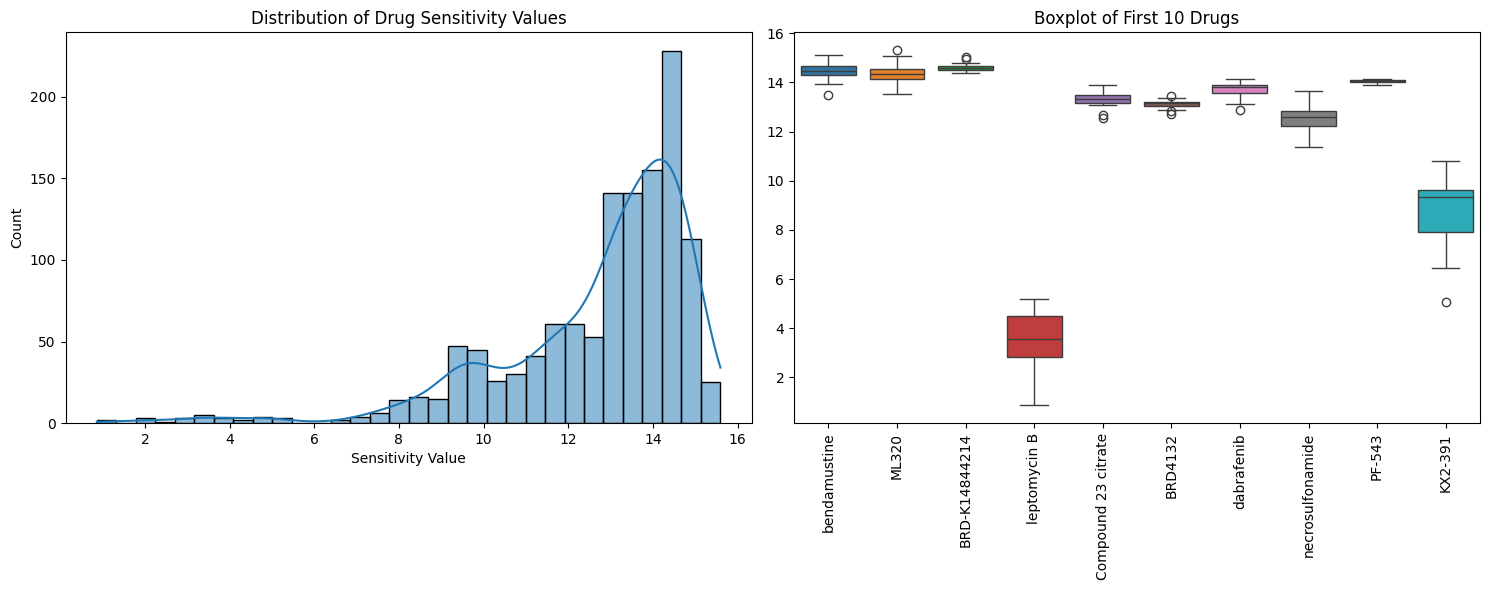

In [8]:
drug_data = perform_eda(data)

In [9]:
drug_data.head()

,bendamustine,ML320,BRD-K14844214,leptomycin B,Compound 23 citrate,BRD4132,dabrafenib,necrosulfonamide,PF-543,KX2-391,...,Compound 1541A,pevonedistat,ISOX,tosedostat,AT13387,BRD-A02303741,BRD-K99006945,GSK525762A,necrostatin-7,nakiterpiosin
0,14.821152,14.286200,14.608184,4.960653,13.530885,13.202820,13.879099,12.839373,14.103941,10.796027,...,14.778758,12.541663,12.113460,12.364817,8.913646,14.860838,13.170200,13.116395,14.548597,11.835573
1,14.304843,14.333355,14.960661,3.552977,13.122806,13.129905,13.911525,12.124210,14.127482,8.489440,...,15.108698,10.936052,11.802052,11.893495,8.326862,15.265313,15.341146,13.509974,14.311074,10.772699
2,14.658052,14.649223,14.547810,3.467945,13.438683,13.441228,13.823993,12.935296,14.052508,9.349282,...,15.012134,12.837987,11.944058,11.694113,8.622052,15.205567,14.039701,13.252381,14.496764,11.387851
3,14.342911,13.657840,14.426898,1.800027,13.242654,13.094447,13.531232,11.987928,14.046877,7.385516,...,14.811534,11.098317,11.480102,11.379716,8.080488,14.906361,13.462326,13.030773,14.466555,9.665608
4,14.655920,14.323148,14.527811,4.491210,13.293485,13.054068,13.807173,12.446720,14.012040,9.540638,...,14.816099,12.075367,11.878005,11.800027,8.595326,14.988143,14.074985,12.959710,14.435152,11.143563


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'bendamustine'),
  Text(1, 0, 'ML320'),
  Text(2, 0, 'BRD-K14844214'),
  Text(3, 0, 'leptomycin B'),
  Text(4, 0, 'Compound 23 citrate'),
  Text(5, 0, 'BRD4132'),
  Text(6, 0, 'dabrafenib'),
  Text(7, 0, 'necrosulfonamide'),
  Text(8, 0, 'PF-543'),
  Text(9, 0, 'KX2-391'),
  Text(10, 0, 'ELCPK'),
  Text(11, 0, 'carboplatin'),
  Text(12, 0, 'SB-525334'),
  Text(13, 0, 'CIL41'),
  Text(14, 0, 'belinostat'),
  Text(15, 0, 'Compound 7d-cis'),
  Text(16, 0, 'lapatinib'),
  Text(17, 0, 'tacrolimus'),
  Text(18, 0, 'pifithrin-mu'),
  Text(19, 0, 'RG-108'),
  Text(20, 0, 'BRD-K97651142'),
  Text(21, 0, 'NVP-BEZ235'),
  Text(22, 0, 'BRD-K01737880'),
  Text(23, 0, 'pluripotin'),
  Text(24, 0, 'GW-

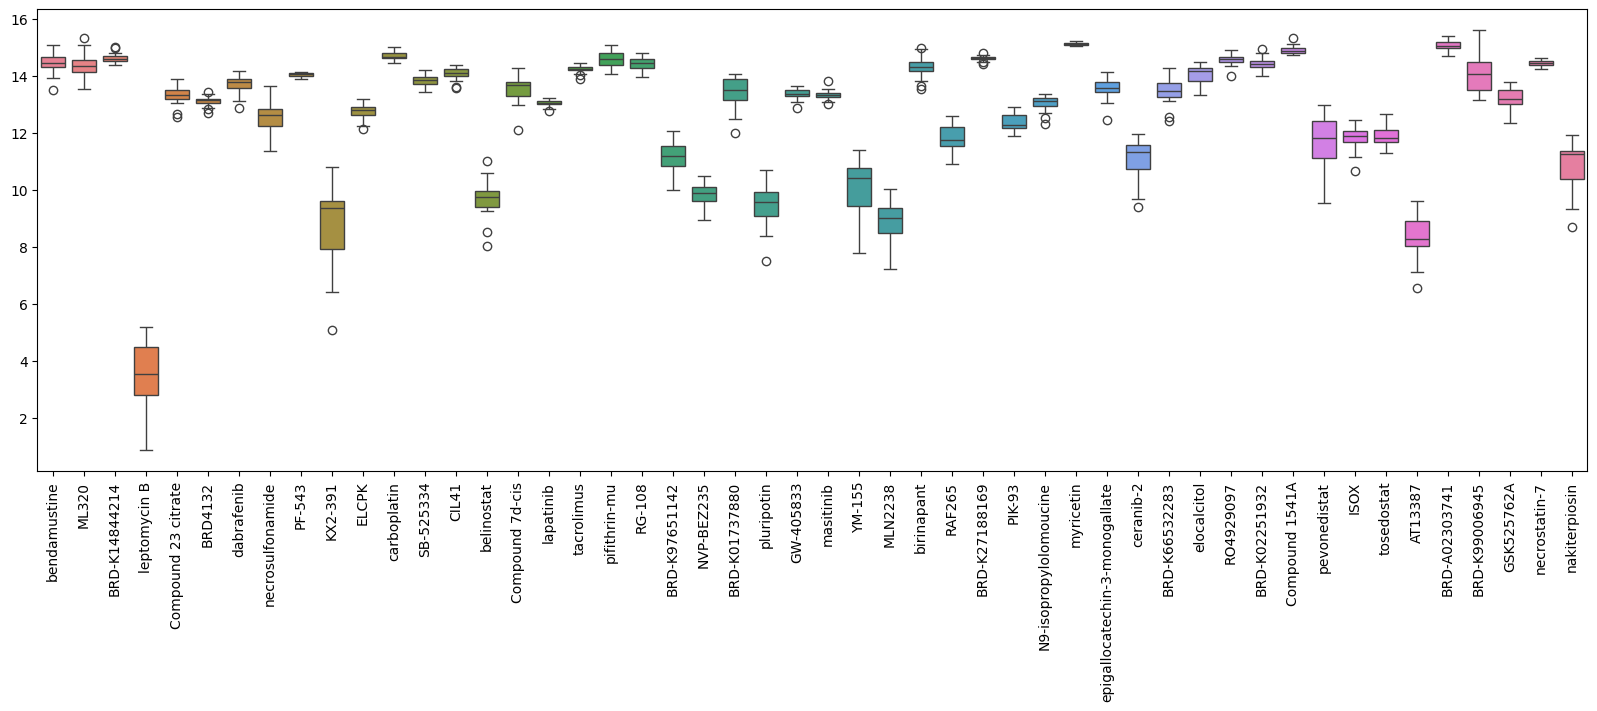

In [10]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=drug_data)
plt.xticks(rotation=90)

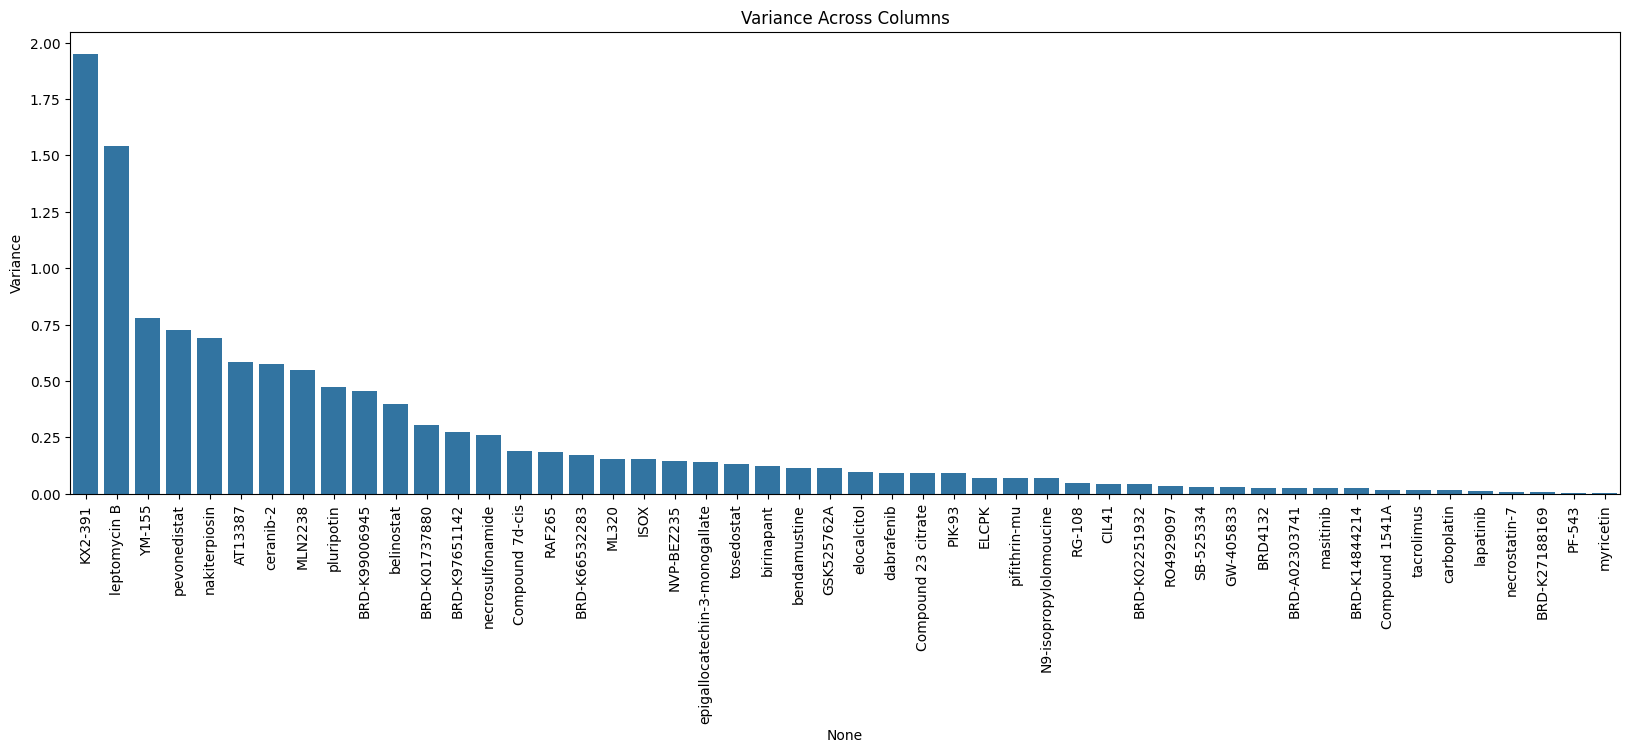

In [11]:
variances = drug_data.var().sort_values(ascending=False)
plt.figure(figsize=(20, 6))
sns.barplot(x=variances.index, y=variances.values)
plt.xticks(rotation=90)
plt.title('Variance Across Columns')
plt.ylabel('Variance')
plt.show()

### Normalize the data

**PCA is sensitive to the variances of the original features**, therefore data normalization before applying PCA is crucial

* PCA works by identifying the directions (principal components) that capture the maximum variance in the data.
* Variables with larger variances can dominate the principal components
  * This means the principal components might primarily reflect the variability of the features with the largest ranges
  * principal components do not capture the underlying relationships in the data
* Drugs with inherently higher variability in their sensitivity scores would disproportionately influence the principal components, potentially masking the contributions and relationships involving drugs with lower score variability.

PCA looks for directions of maximum variance, standardization ensures that each feature contributes more equally to the determination of the principal components

In [12]:
# Create the scaler and standardize the data
scaler = StandardScaler()
drug_data = scaler.fit_transform(drug_data)


In [13]:
print("Type of drug_data:", type(drug_data))
print("Shape of drug_data:", drug_data.shape)
print("First 5 rows and columns of drug_data:\n", drug_data[:5, :5])

Type of drug_data: <class 'numpy.ndarray'>
Shape of drug_data: (25, 50)
First 5 rows and columns of drug_data:
 [[ 1.11745915 -0.14919196 -0.01756464  1.22165355  0.70067562]
 [-0.4261314  -0.02638244  2.24640919  0.06536914 -0.66625469]
 [ 0.62984536  0.7962644  -0.40535119 -0.00447747  0.3918278 ]
 [-0.3123208  -1.78569382 -1.18197636 -1.3745291  -0.26480228]
 [ 0.62347222 -0.0529662  -0.5338052   0.83604629 -0.09453399]]


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '

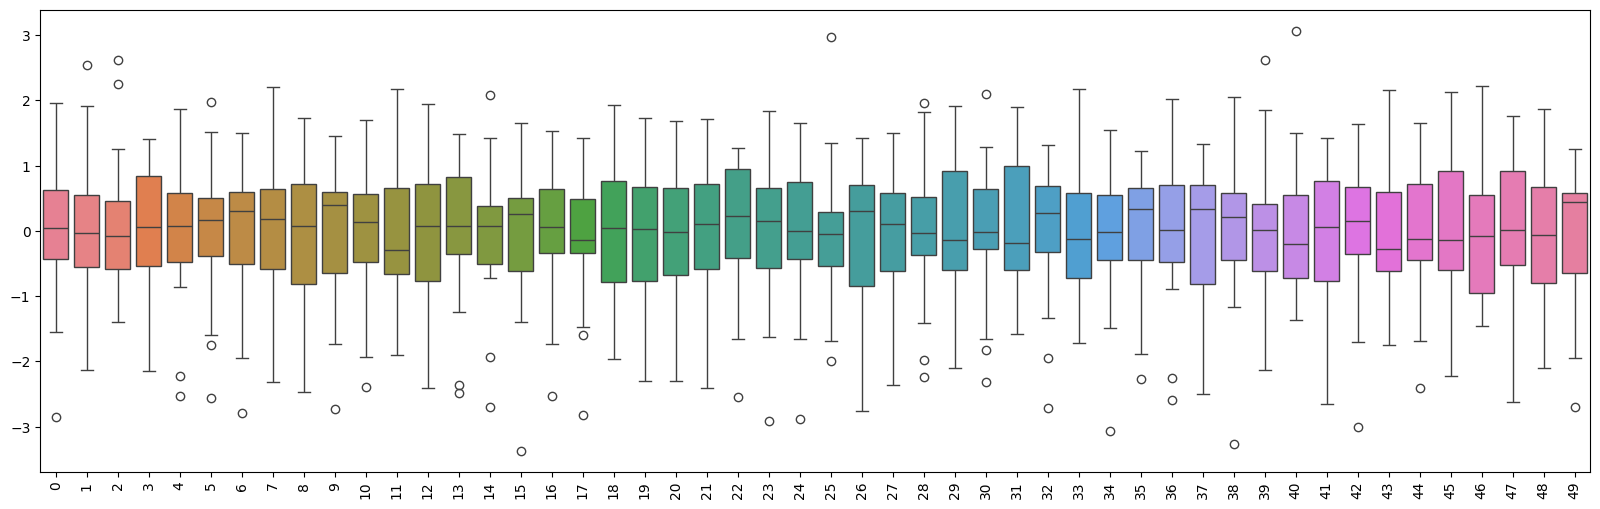

In [14]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=drug_data)
plt.xticks(rotation=90)

In [15]:
drug_data.var(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

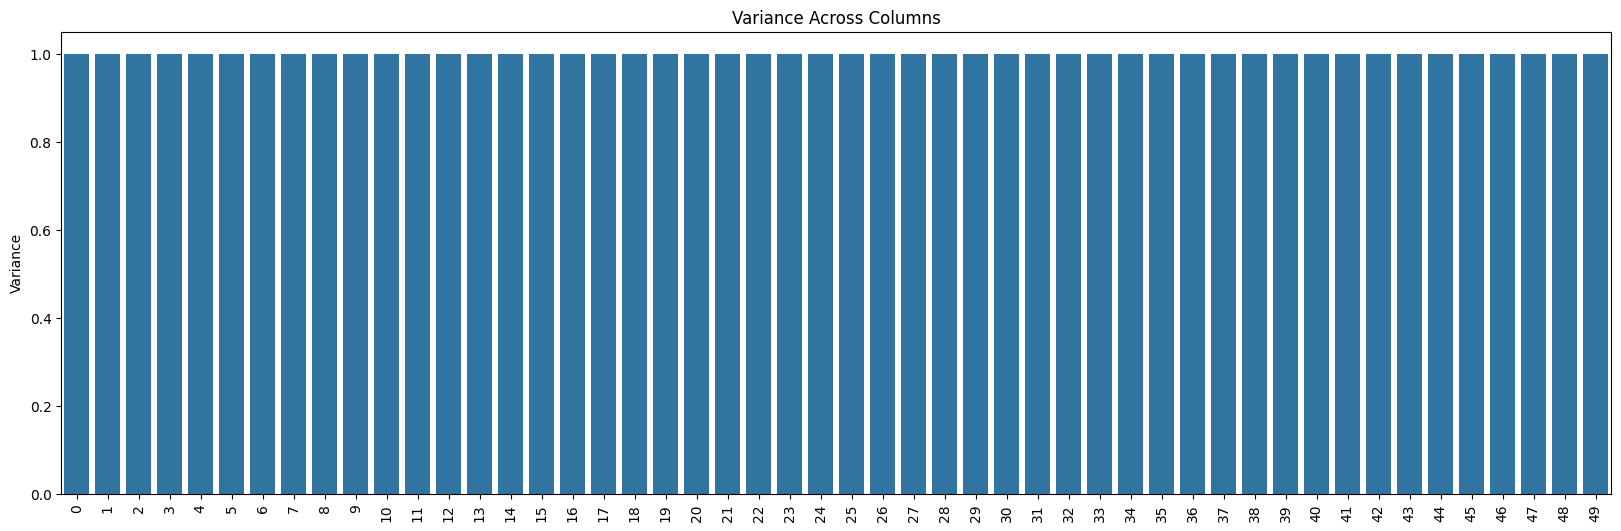

In [16]:
variances = drug_data.var(axis=0)#.sort_values(ascending=False)
plt.figure(figsize=(20, 6))
sns.barplot(x=range(0,len(variances)), y=variances)
plt.xticks(ticks=range(0, len(variances)), rotation=90)
plt.title('Variance Across Columns')
plt.ylabel('Variance')
plt.show()

## PCA Implementation

* Apply PCA transformation
* Calculate explained variance


### Apply PCA transformation

In [17]:
# Create the PCA instance and fit and transform the data with pca
pca = PCA()
pc = pca.fit_transform(drug_data)


In [18]:
print("Type of pc:", type(pc))
print("Shape of pc:", pc.shape)
print("First 5 rows and columns of pc:\n", pc[:5, :5])

Type of pc: <class 'numpy.ndarray'>
Shape of pc: (25, 25)
First 5 rows and columns of pc:
 [[ 3.64790724  3.78552267  1.33659718 -0.20864174 -2.17346721]
 [ 0.32125071 -5.9898321   4.18994535 -0.20697045  0.17194817]
 [ 3.83231009  1.28508967 -0.47749898 -2.19393142  3.98217509]
 [-5.63359232  3.69098317 -3.47828106 -0.8034397   0.44613498]
 [ 0.17402269  1.51797501  0.16606953  2.91234111  0.42116796]]


**Note:**

* Original `drug_data` had 25 rows (observations), so `pc` also had 25 rows representing patients
* We didn't specify the number of components (`n_components`) when creating the PCA object (`pca = PCA()`), scikit-learn defaults to calculating `min(n_samples, n_features)` components. Original dataset had 50 features, PCA still only computes 25 components because the maximum number of meaningful principal components is limited by the number of samples (you can't find more independent directions of variance than you have data points).

The `fit_transform` method did two things:

1. `fit`: It analyzed drug_data to find the 25 principal component directions (axes) based on the variance and correlations between your original features.
2. `transform`: It then projected your original 25 samples from their original feature space (with >=25 dimensions) onto this new coordinate system defined by the 25 principal components


In [19]:
pc_df = pd.DataFrame(pc, columns=[f'PC_{i}' for i in range(1, pc.shape[1]+1)])
pc_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_16,PC_17,PC_18,PC_19,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25
0,3.647907,3.785523,1.336597,-0.208642,-2.173467,-0.159574,-0.201224,-0.175144,-0.442335,0.125566,...,0.015509,0.053778,-0.106066,-0.353473,-0.059685,-0.655202,0.315228,-0.239004,0.257046,-2.795993e-16
1,0.321251,-5.989832,4.189945,-0.206970,0.171948,0.960831,-0.520194,1.106246,-0.674214,-0.811364,...,-0.724327,-0.503311,0.348717,-0.460284,-0.166123,0.121399,0.262114,0.042369,-0.096848,-2.795993e-16
2,3.832310,1.285090,-0.477499,-2.193931,3.982175,-0.967499,-0.351455,0.389307,0.007497,0.070364,...,0.080597,-0.748926,-0.429462,-0.277130,-0.028362,0.054581,0.009554,0.045150,0.040776,-2.795993e-16
3,-5.633592,3.690983,-3.478281,-0.803440,0.446135,0.610747,-2.052404,0.316239,-1.076850,-1.359736,...,0.029642,0.142202,0.806519,0.175962,-0.013190,-0.119514,-0.072060,0.053852,0.077116,-2.795993e-16
4,0.174023,1.517975,0.166070,2.912341,0.421168,-0.887175,-1.127990,-1.452414,-1.104615,-0.970554,...,0.832998,-0.053671,-0.443638,-0.031360,-0.348642,0.422218,0.010565,-0.405376,-0.039028,-2.795993e-16


#### PCA context

* PCA aims to summarize a large set of correlated variables with a smaller number of representative variables
* The goal is to find a low-dimensional representation of the data that retains as much of the original variation as possible
* **The first principal component** is defined as the linear combination of the original features that has the largest sample variance
* **Subsequent principal components** are then found such that they have the maximal variance out of all linear combinations that are uncorrelated with the preceding principal components
  * For example, the second principal component must be uncorrelated with the first, the third with the first two, and so on
* By transforming the original correlated variables into a set of uncorrelated principal components, PCA effectively removes redundancy in the data
  * Correlated variables inherently contain overlapping information. Decorrelation ensures that each principal component captures a distinct aspect of the data's variability

In [20]:
drug_data_normalised = pd.DataFrame(drug_data, columns=data.columns[1:])

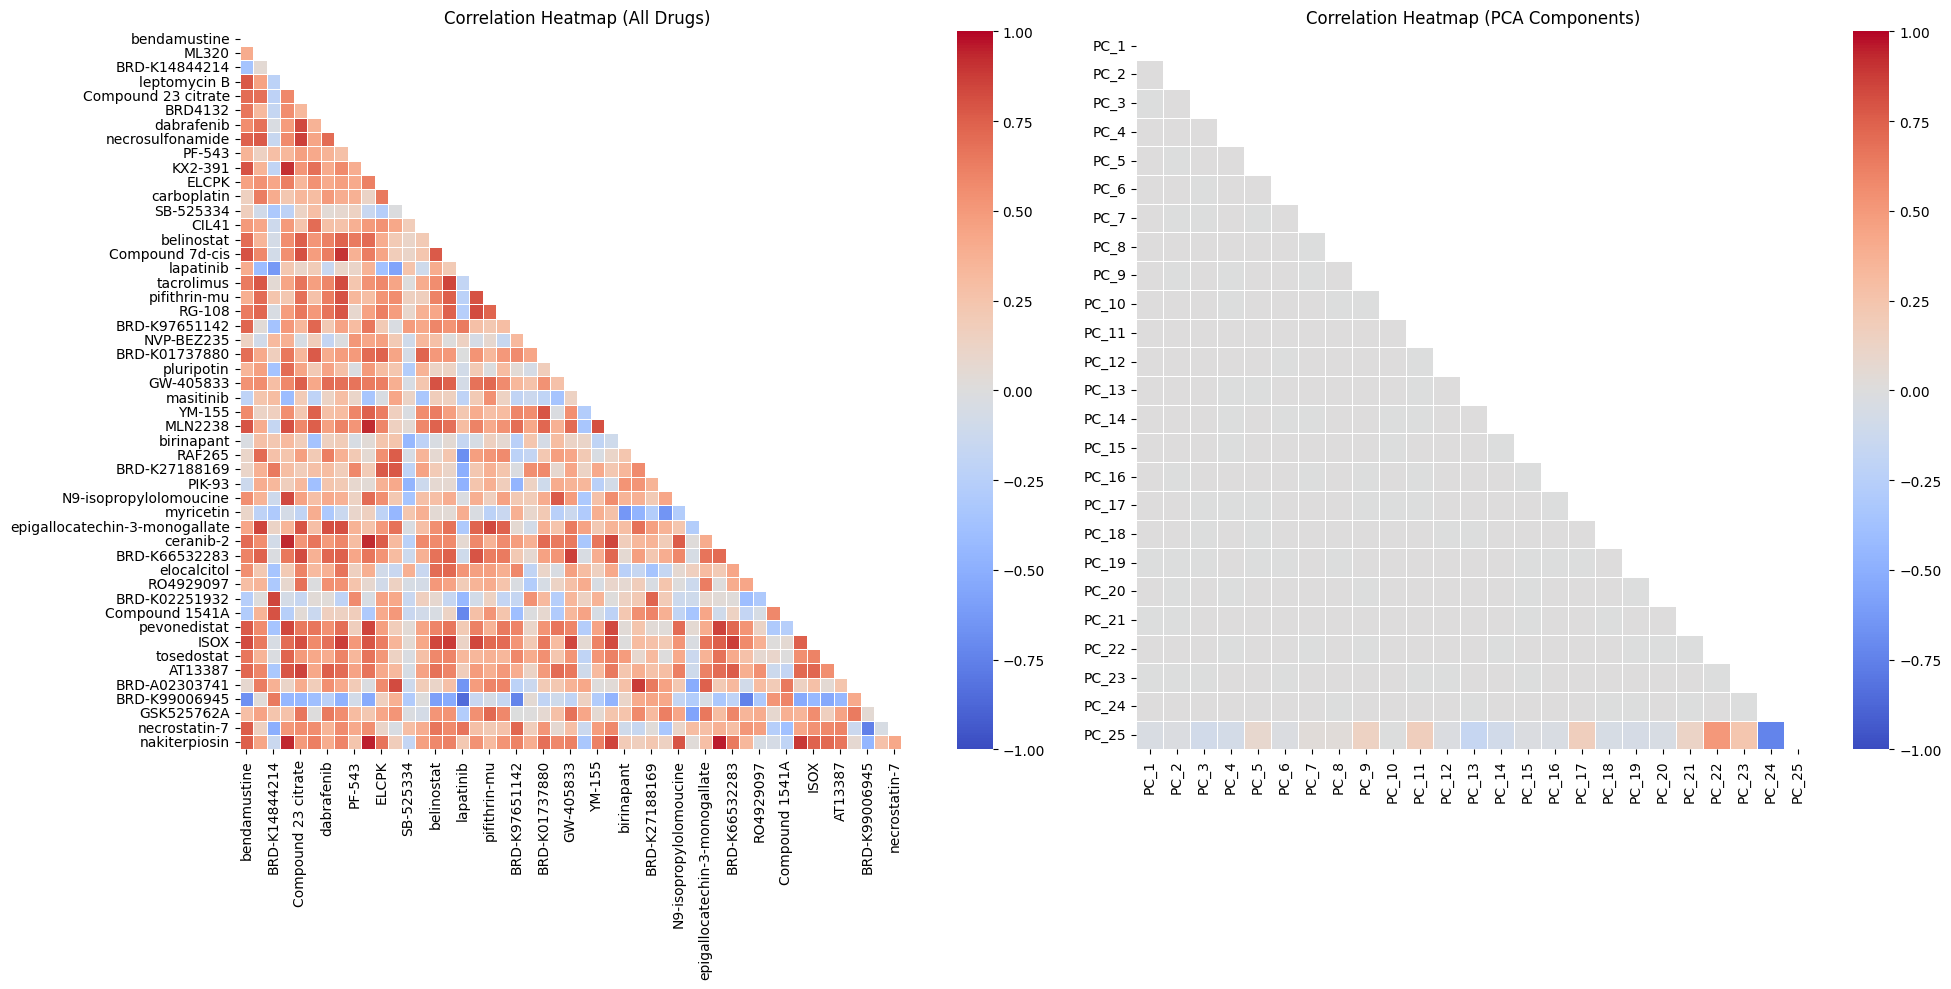

In [21]:
# Correlation heatmap
# plt.figure(figsize=(12, 10))

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

mask = np.triu(np.ones_like(drug_data_normalised.corr(), dtype=bool))
sns.heatmap(drug_data_normalised.corr(), mask=mask, annot=False, cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Correlation Heatmap (All Drugs)')

mask = np.triu(np.ones_like(pc_df.corr(), dtype=bool))
sns.heatmap(pc_df.corr(), mask=mask, annot=False, cmap='coolwarm', 
            linewidths=0.5, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Correlation Heatmap (PCA Components)')


plt.tight_layout()
    
plt.show()
plt.close()

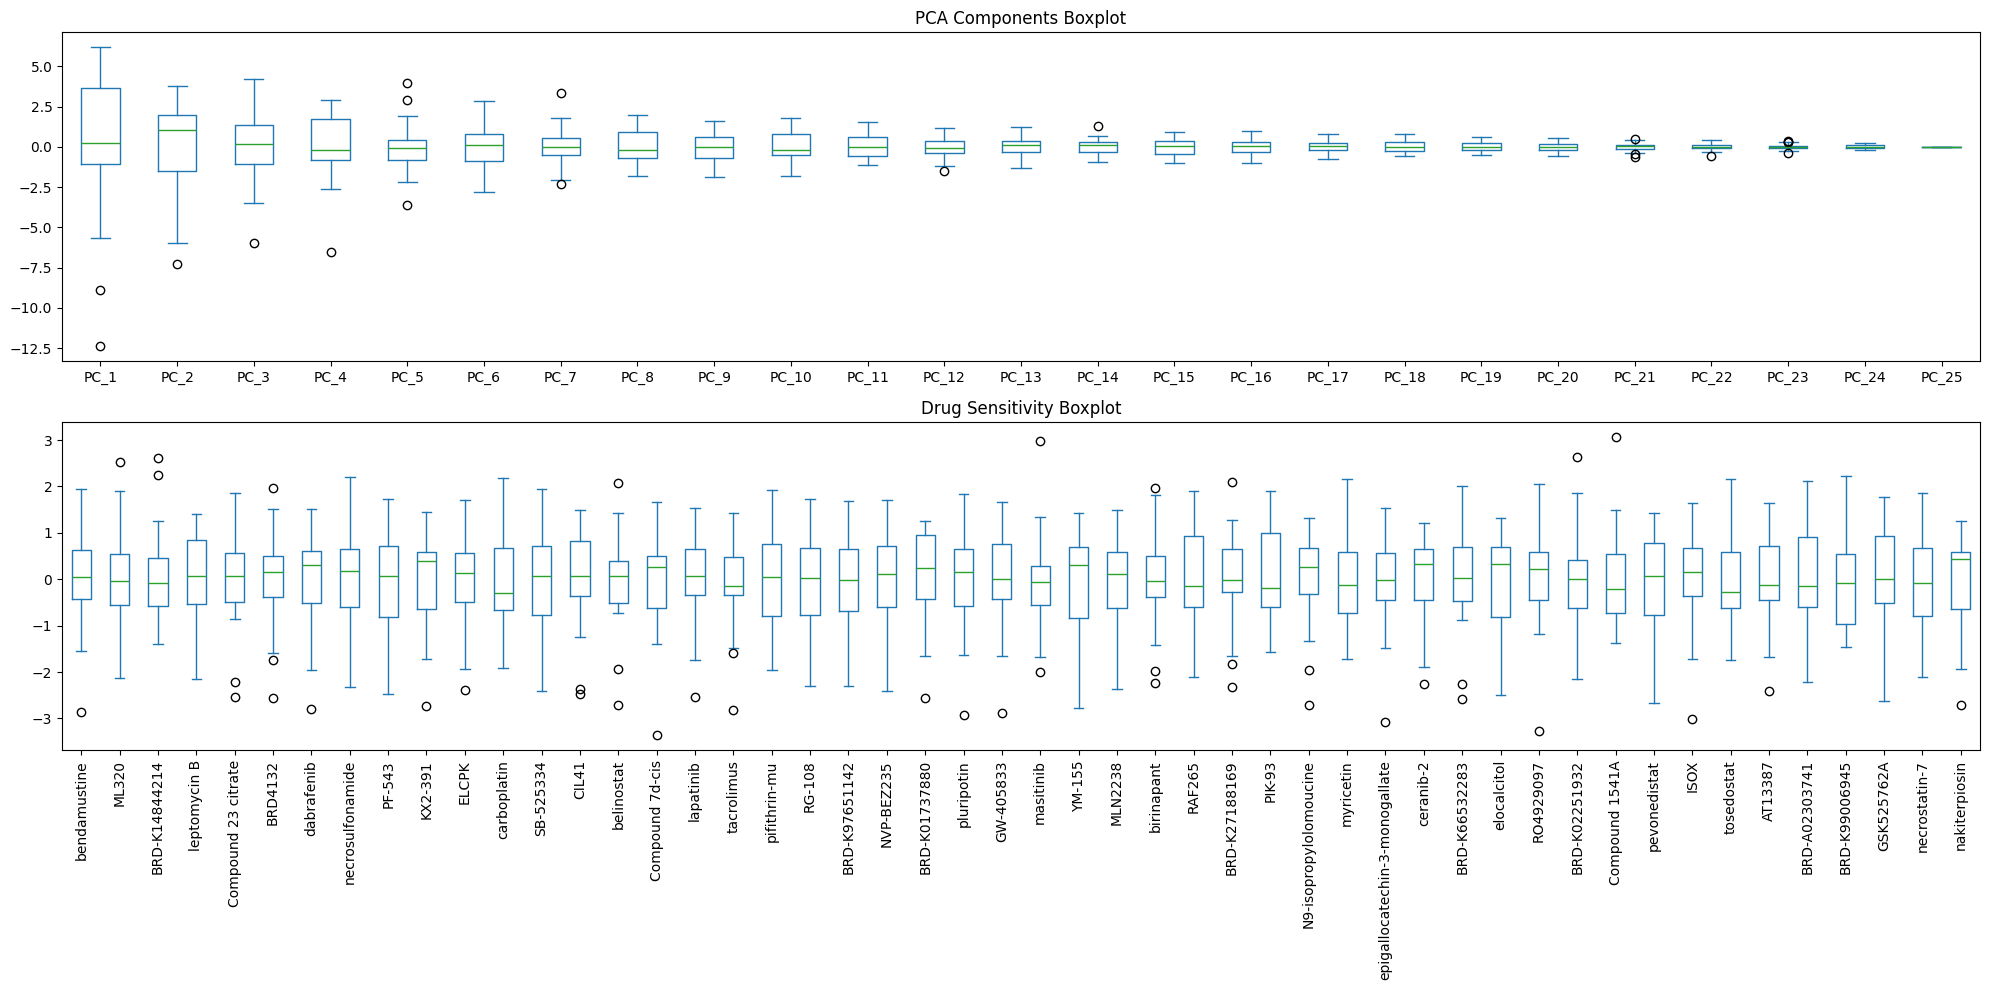

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

pc_df.plot(kind="box", title="PCA Components Boxplot", ax=axes[0])
drug_data_normalised.plot(kind="box", title="Drug Sensitivity Boxplot", ax=axes[1])
plt.xticks(rotation=90)
plt.tight_layout()

***Note:***

* PCA successfully achieved its goal of decorrelating our dataset

* Decorrelation:
  * The variance originally shared (correlation) between features in the original dataset has been reorganized and captured along these new, independent PC axes
* Why focus on maximizing variance during decorrelation
  * High-variance directions contain more signal, while low-variance directions often represent noise
  * Allows PCA to identify the most "important" directions (data that account for the greatest spread)
* These uncorrelated components that capture maximum variance provide a more efficient and interpretable representation of the data compared to the original correlated features

The first principal component is defined as the linear combination of features that has the largest variance, subject to the constraint that the coefficients in the linear combination is one. Subsequent principal components are found by maximizing variance among linear combinations uncorrelated with previous components

In [23]:
# pc_df.head()

In [24]:
# # Calculate cumulative variance = cumulative proportion of variance explained by the principal components
# variances = pc_df.var(axis=0)
# cumulative_variance = variances.cumsum() / variances.sum()

# # Plot cumulative variance
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
# plt.title('Cumulative Variance Explained by Principal Components')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Variance Explained')
# plt.grid()
# plt.show()

### Explained variance calculation

* PCA seeks a low-dimensional representation of a dataset that captures as much as possible of the variation in the original data

* **Variance Explained by a PC:**
  * The variance explained by the `nth` principal component is the variance of its scores

* **Total Variance:**
  * The total variance present in the original data (assuming variables are centered to have mean zero) is the sum of the variances of the original features
  
* **Relationship between PC Variance and Total Variance:**
  * A key property is that the ***sum of the variances of all principal components equals the total variance of the original data***
  * This means maximizing the variance of the `n` principal components is equivalent to minimizing the reconstruction error when approximating the data with those `n`  components

* **Proportion of Variance Explained (PVE) | Explained Variance Ratio:**
  * The PVE of the `mth` principal component is calculated as the variance of the `mth` principal component scores divided by the total variance in the original data
  * The PVEs for all principal components (up to min(n-1, p)) sum to one

* **Cumulative PVE:** 
  * The cumulative PVE of the principal components is simply the sum of the PVEs for those components

In [25]:
## Access the explained variance directly
explained_variance = pca.explained_variance_
print("Explained variance by component:", explained_variance)

Explained variance by component: [2.06118885e+01 9.46481592e+00 5.66619038e+00 4.25914905e+00
 2.86483250e+00 1.91158440e+00 1.59439385e+00 1.22821102e+00
 9.13563089e-01 8.09987389e-01 5.90796907e-01 4.07254006e-01
 3.73077915e-01 2.98129789e-01 2.48097781e-01 2.31592814e-01
 1.58434105e-01 1.29071221e-01 8.11724160e-02 7.48451289e-02
 6.29952247e-02 5.23843184e-02 3.73057774e-02 1.35597766e-02
 8.14330803e-32]


In [26]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio by component:", explained_variance_ratio)

Explained variance ratio by component: [3.95748260e-01 1.81724466e-01 1.08790855e-01 8.17756618e-02
 5.50047841e-02 3.67024205e-02 3.06123619e-02 2.35816516e-02
 1.75404113e-02 1.55517579e-02 1.13433006e-02 7.81927692e-03
 7.16309597e-03 5.72409195e-03 4.76347739e-03 4.44658203e-03
 3.04193482e-03 2.47816745e-03 1.55851039e-03 1.43702647e-03
 1.20950831e-03 1.00577891e-03 7.16270926e-04 2.60347711e-04
 1.56351514e-33]


In [27]:
# Option 3: Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("Cumulative explained variance:", cumulative_explained_variance)


Cumulative explained variance: [0.39574826 0.57747273 0.68626358 0.76803924 0.82304403 0.85974645
 0.89035881 0.91394046 0.93148087 0.94703263 0.95837593 0.96619521
 0.9733583  0.9790824  0.98384587 0.98829246 0.99133439 0.99381256
 0.99537107 0.99680809 0.9980176  0.99902338 0.99973965 1.
 1.        ]


### Visualize the explained variance

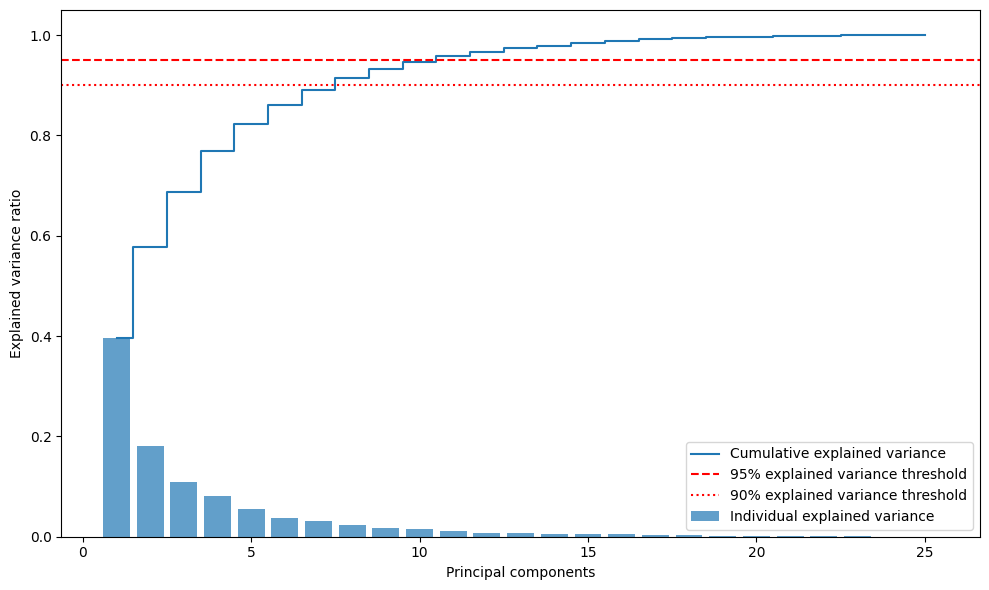

In [28]:
# Visualize the explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% explained variance threshold')
plt.axhline(y=0.90, color='r', linestyle='dotted', label='90% explained variance threshold')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## Determine optimal number of components

* Variance Threshold
* Scree Plot (Elbow Method)


### Variance Threshold
  
* Find number of components that explain at least 95% (or 99%) of variance
* Selects components that collectively explain a predefined percentage (e.g., 95%) of total variance
* Ensures you keep enough information while reducing dimensions
* Provides a clear cutoff criterion that doesn't require subjective judgment (Automated selection)

In [29]:
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
# np.argmax(): This function returns the index of the first occurrence of the maximum value in the array.

print(f"Number of components for 95% variance: {n_components_95}")


Number of components for 95% variance: 11


### Scree Plot (Elbow Method)
* Helps identify the point where additional components yield diminishing returns (Visual identification)
  * Balances model complexity against information retention
* The "elbow" often marks where principal components transition from capturing signal to capturing noise (Noise reduction)
* Visually reveals the relative importance of components, making the decision process more transparent

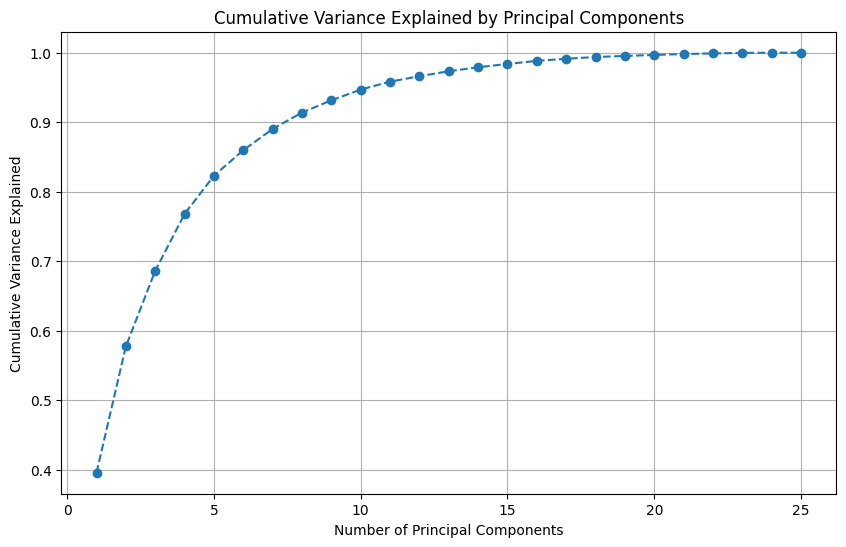

In [30]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

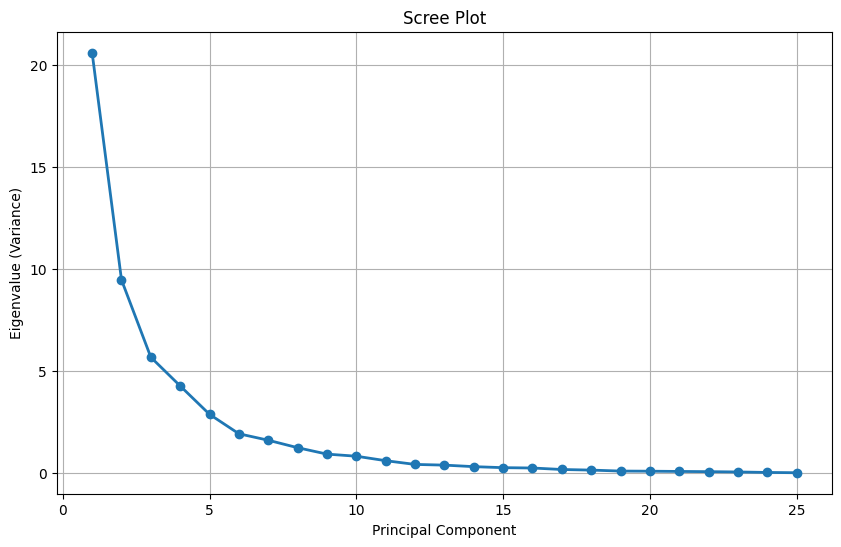

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Variance)')
plt.grid(True)
plt.show()

* The eigenvalue of a component equals the variance of the data points when projected onto that component
  * Eigenvalue as a number that tells you "how much variance" is associated with a specific eigenvector (which represents a principal component direction)
  * When you project your data onto that eigenvector's direction, the variance you calculate for those projected points will be exactly the eigenvalue

## Automated Selection with PCA

* Instead of manually determining the number of components, you can initialize PCA with a variance threshold:


In [32]:
# Automatically select components to explain 90% of variance
optimal_pca = PCA(n_components=0.90)  # Keep enough components to explain 90% of variance
pc_auto = optimal_pca.fit_transform(drug_data)
print(f"Number of components selected: {optimal_pca.n_components_}")

optimal_pca_df = pd.DataFrame(
    data=pc_auto,
    columns=[f'PC{i+1}' for i in range(pc_auto.shape[1])]
)
optimal_pca_df['Patient ID'] = data["Patient ID"]

print(f"Optimal PCA DataFrame: \n{optimal_pca_df.head()}")

Number of components selected: 8
Optimal PCA DataFrame: 
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.647907  3.785523  1.336597 -0.208642 -2.173467 -0.159574 -0.201224   
1  0.321251 -5.989832  4.189945 -0.206970  0.171948  0.960831 -0.520194   
2  3.832310  1.285090 -0.477499 -2.193931  3.982175 -0.967499 -0.351455   
3 -5.633592  3.690983 -3.478281 -0.803440  0.446135  0.610747 -2.052404   
4  0.174023  1.517975  0.166070  2.912341  0.421168 -0.887175 -1.127990   

        PC8    Patient ID  
0 -0.175144  TCGA-D8-A1JU  
1  1.106246  TCGA-AC-A3QQ  
2  0.389307  TCGA-C8-A12Q  
3  0.316239  TCGA-AR-A1AY  
4 -1.452414  TCGA-A8-A0A2  


## Feature Loadings

* Feature Loadings = Contribution of each original feature to each principal component
* Shows which original features most strongly influence each principal component - **Feature influence**
* Helps interpret what each principal component represents - **Component interpretation**
* Identifies which original features are most important for your dataset's structure - **Feature selection**
* Reveals relationships between features in your high-dimensional space - **Dimensionality insights**

High absolute values (positive or negative) indicate strong influence on that component. A loading of 0 means no influence

In [33]:
loadings = optimal_pca.components_

# Get feature names (assuming you have them in a list or as column names)
feature_names = data.iloc[:, 1:].columns  # Or your list of feature names

# Create a DataFrame with the loadings
loadings_df = pd.DataFrame(
    loadings,
    columns=feature_names,
    index=[f'PC_{i+1}' for i in range(loadings.shape[0])]
)

# loading_df = pd.DataFrame(
#     loadings.T,
#     columns=[f'PC{i+1}' for i in range(loadings.shape[0])],
#     index=drug_data_normalised.columns
# )
loadings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, PC_1 to PC_8
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   bendamustine                    8 non-null      float64
 1   ML320                           8 non-null      float64
 2   BRD-K14844214                   8 non-null      float64
 3   leptomycin B                    8 non-null      float64
 4   Compound 23 citrate             8 non-null      float64
 5   BRD4132                         8 non-null      float64
 6   dabrafenib                      8 non-null      float64
 7   necrosulfonamide                8 non-null      float64
 8   PF-543                          8 non-null      float64
 9   KX2-391                         8 non-null      float64
 10  ELCPK                           8 non-null      float64
 11  carboplatin                     8 non-null      float64
 12  SB-525334                       8 non-n

In [34]:
print("Contribution of each original feature to each principal component")
loadings_df

Contribution of each original feature to each principal component


,bendamustine,ML320,BRD-K14844214,leptomycin B,Compound 23 citrate,BRD4132,dabrafenib,necrosulfonamide,PF-543,KX2-391,...,Compound 1541A,pevonedistat,ISOX,tosedostat,AT13387,BRD-A02303741,BRD-K99006945,GSK525762A,necrostatin-7,nakiterpiosin
PC_1,0.188893,0.158907,-0.014409,0.184616,0.188557,0.148854,0.169982,0.195003,0.114682,0.186589,...,0.013166,0.186654,0.211779,0.153139,0.186287,0.091061,-0.092112,0.125780,0.127629,0.184714
PC_2,0.130845,-0.140145,-0.233375,0.073321,-0.021347,0.107959,-0.080697,-0.013266,-0.024182,0.121842,...,-0.272325,0.094608,0.014560,0.064277,0.026162,-0.255982,-0.258407,-0.169401,0.188433,0.083508
PC_3,-0.021312,-0.084223,0.186021,0.116362,-0.187231,0.127776,-0.129210,-0.165453,0.120737,0.124947,...,0.026282,-0.007923,-0.035613,0.082174,-0.057860,-0.049318,0.141969,-0.145518,-0.050762,0.125907
PC_4,0.002208,0.054969,-0.168718,0.204135,0.007250,-0.127992,0.012934,-0.043828,-0.228499,0.082702,...,-0.175538,0.146641,-0.057821,0.019380,0.129659,-0.015643,0.014241,0.011453,-0.116959,0.151041
PC_5,0.032004,0.169326,-0.154553,-0.061343,-0.063709,0.255198,0.039662,-0.012972,-0.180148,-0.060818,...,-0.012056,0.095784,-0.037420,-0.213437,-0.050259,0.151289,0.119979,-0.133028,-0.047117,-0.040750
PC_6,0.026600,-0.001502,-0.203015,0.044929,0.140286,0.042471,0.153289,-0.052095,0.269030,-0.099810,...,-0.158710,-0.120513,-0.109148,0.034131,0.272596,0.106136,-0.022863,-0.083687,0.295653,-0.157441
PC_7,0.110011,0.061453,-0.006347,0.049683,-0.096940,0.049480,-0.080599,0.157775,-0.281277,-0.054539,...,0.088570,0.008416,-0.082869,0.363718,-0.125535,0.122516,-0.145911,-0.100268,0.119357,0.078340
PC_8,-0.007307,-0.195364,-0.010461,0.000593,0.019415,0.083812,0.053971,-0.126673,0.113933,-0.000942,...,-0.087146,0.140472,-0.021129,-0.089389,-0.021654,0.044740,-0.014215,0.338453,-0.170848,0.043675


### Visualization - Feature Loadings

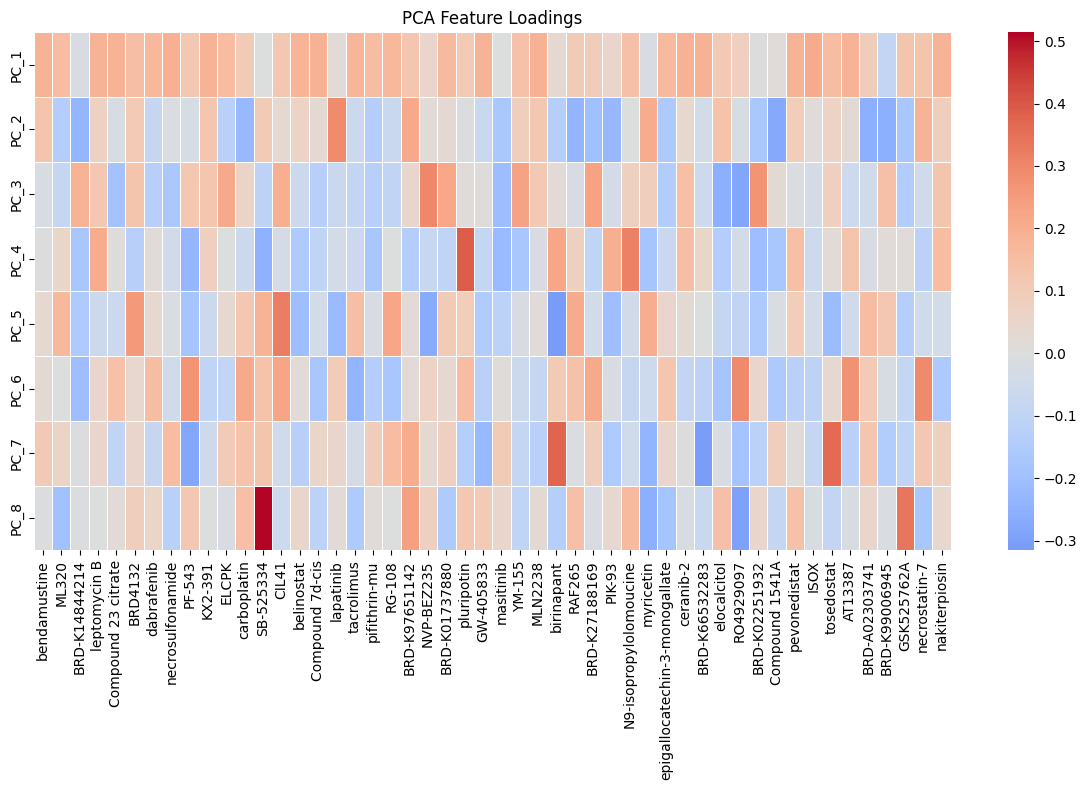

In [35]:


# Create a heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(
    loadings_df, 
    cmap='coolwarm',
    center=0,
    annot=False,
    fmt=".2f",
    linewidths=.5
)
plt.title('PCA Feature Loadings')
plt.tight_layout()
plt.show()


In [36]:
# Select top n contributing features for each component
def get_top_features(loadings_df, n=10):
    top_features = pd.DataFrame()
    
    for pc in loadings_df.index:
        pc_loadings = loadings_df.loc[pc].abs().sort_values(ascending=False)
        top_features[pc] = pc_loadings.index[:n]
        
    return top_features

top_features = get_top_features(loadings_df)
print("Top contributing features for each principal component:")
top_features

Top contributing features for each principal component:


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
0,ISOX,lapatinib,NVP-BEZ235,pluripotin,CIL41,RO4929097,birinapant,SB-525334
1,necrosulfonamide,Compound 1541A,RO4929097,N9-isopropylolomoucine,birinapant,necrostatin-7,tosedostat,GSK525762A
2,ceranib-2,BRD-K99006945,BRD-K02251932,SB-525334,NVP-BEZ235,AT13387,BRD-K66532283,RO4929097
3,MLN2238,BRD-A02303741,elocalcitol,PF-543,BRD4132,PF-543,PF-543,myricetin
4,BRD-K66532283,RAF265,BRD-K27188169,birinapant,RG-108,tacrolimus,myricetin,BRD-K97651142
5,Compound 7d-cis,BRD-K14844214,YM-155,masitinib,lapatinib,CIL41,GW-405833,ML320
6,bendamustine,PIK-93,BRD-K01737880,leptomycin B,tosedostat,carboplatin,BRD-K97651142,epigallocatechin-3-monogallate
7,Compound 23 citrate,carboplatin,ELCPK,BRD-K02251932,RAF265,BRD-K27188169,RO4929097,necrostatin-7
8,GW-405833,BRD-K97651142,masitinib,PIK-93,belinostat,BRD-K14844214,RG-108,N9-isopropylolomoucine
9,pevonedistat,myricetin,CIL41,myricetin,PIK-93,elocalcitol,necrosulfonamide,BRD-K01737880


## K-means Cluster analysis

* K-means seeks to group observations so that those within each cluster are more closely related to one another than objects assigned to different clusters

* "Good" clustering is one for which the within-cluster variation is as small as possible
* K-means aims to minimize the total *within-cluster variation* summed over all K cluster
* *Within-cluster variation:*
  * Describes how dispersed the data points are within their clusters
  * In K-means specifically, the *within-cluster sum-of-squares (Inertia)* is the standard way to quantify Within-cluster variation, but other clustering algorithms might use different mathematical formulations to measure variation

### Inertia (within-cluster sum-of-squares)

* Inertia is a mathematical measure that quantifies how tightly grouped the data points are within their assigned clusters

* K-means clustering uses an iterative optimization strategy to minimize inertia

#### Variation of Increasing with Number of Clusters

* Inertia always decreases or stays the same, never increases
* The rate of decrease typically follows a curve that looks like this:
  * Rapid decrease initially (adding the first few clusters)
  * Gradually diminishing returns as K continues to increase
  * Eventually, minimal improvements with additional clusters

**Why This Happens?**

* With more clusters, each data point can be assigned to a centroid that's closer to it
* When K=1: Maximum inertia (all points compared to global mean)
* When K=n (number of data points): Zero inertia (each point is its own cluster)
* The first few clusters capture the major structure in the data, while additional clusters only capture finer details (*Diminishing returns*)


#### The Elbow Method

This behavior forms the basis of the popular "elbow method" for determining the optimal number of clusters:

1. Plot inertia against K (for K=1,2,3...)
2. Look for the "elbow point" where the curve bends sharply
3. This point represents where adding more clusters stops providing significant reduction in inertia

**Important Considerations:**

1. Inertia will always decrease as K increases, even if you're adding meaningless clusters
2. This is why we look for the elbow point rather than simply minimizing inertia


### Silhouette Score

* Evaluating clustering quality that addresses some limitations of using inertia alone
* It measures how well-separated clusters are by considering both:
  * How similar each point is to its own cluster (cohesion)
  * How different it is from other clusters (separation)

**Is each data point placed in the right cluster?**

* How close a point is to other points in its assigned cluster
* How close that same point is to points in the nearest neighboring cluster

### Interpretation of Silhouette Score

* The silhouette score ranges from -1 to 1:
  * Close to +1: The point is well matched to its own cluster and far from neighboring clusters
  * Close to 0: The point lies near the boundary between two clusters
  * Close to -1: The point might be assigned to the wrong cluster

* The overall silhouette score of a cluster is simply the average of all individual silhouette scores.

#### Finding Optimal K Using Silhouette

Unlike inertia which always decreases as K increases, the silhouette score typically:

* Increases as K approaches the natural number of clusters
* Reaches a maximum at or near the optimal K
* Decreases as K becomes too large

* This makes it particularly useful for determining the optimal number of clusters - you simply choose the K value that maximizes the average silhouette score.



In [37]:
# 1. Determine optimal number of clusters using the Elbow method

inertia = []
silhouette_scores = []
k_range = range(2, 11)  # Testing from 2 to 10 clusters

# Exclude the Patient ID column for clustering
pca_data = optimal_pca_df.drop('Patient ID', axis=1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score (only valid for k >= 2)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(pca_data, labels))
    print(f"Silhouette score for {k} clusters: {silhouette_scores[-1]}")

Silhouette score for 2 clusters: 0.315860568817066
Silhouette score for 3 clusters: 0.2339948659392648
Silhouette score for 4 clusters: 0.19232273760529722
Silhouette score for 5 clusters: 0.2128037884102211
Silhouette score for 6 clusters: 0.2215781206218203
Silhouette score for 7 clusters: 0.188253895245279
Silhouette score for 8 clusters: 0.16503544411475235
Silhouette score for 9 clusters: 0.13979820154212977
Silhouette score for 10 clusters: 0.13772690406314386


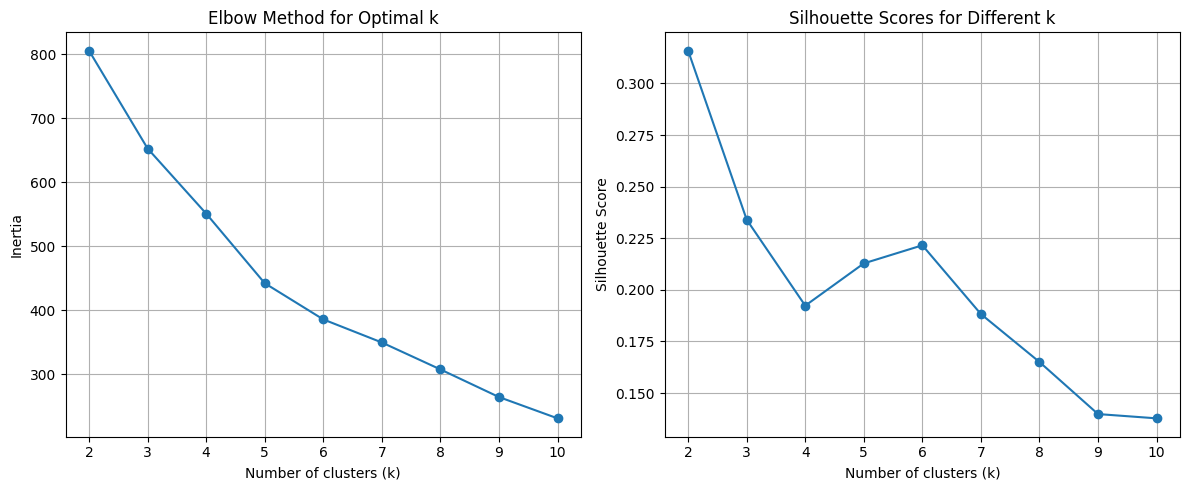

In [38]:
# Plot the Elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.grid(True)
plt.tight_layout()
plt.show()


K-means seeks to group observations so that those within each cluster are more closely related to one another than objects assigned to different clusters
"good" clustering is one for which the within-cluster variation is as small as possible
K-means aims to minimize the total within-cluster variation summed over all K cluster

Distortion is the sum of the squares of distances between each data point and its assigned cluster center
Distortion generally has an inverse relationship with the number of clusters
i.e., As the number of clusters increases, distortion tends to decrease



In [39]:
# 2. Apply K-means with the optimal k
optimal_k = 2  # optimal k from the plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
#clusters = kmeans.fit_predict(pca_data)

clusters = kmeans.fit(pca_data)

print(f"Number of clusters: {optimal_k}")
print(f"Cluster centers:\n{kmeans.cluster_centers_}")
print(f"Cluster labels for each patient sample: {clusters.labels_}, shape: {clusters.labels_.shape}")


Number of clusters: 2
Cluster centers:
[[-7.14637747  0.54032222 -1.29139652  0.44272758 -0.69631416  0.23079706
   0.30156275  0.29610771]
 [ 1.78659437 -0.13508055  0.32284913 -0.1106819   0.17407854 -0.05769926
  -0.07539069 -0.07402693]]
Cluster labels for each patient sample: [1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1], shape: (25,)


In [40]:
# 3. Add cluster labels to the dataframe
optimal_pca_df['Cluster'] = clusters.labels_
print("First 5 rows of PCA DataFrame with cluster labels:")
optimal_pca_df.head()


First 5 rows of PCA DataFrame with cluster labels:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Patient ID,Cluster
0,3.647907,3.785523,1.336597,-0.208642,-2.173467,-0.159574,-0.201224,-0.175144,TCGA-D8-A1JU,1
1,0.321251,-5.989832,4.189945,-0.206970,0.171948,0.960831,-0.520194,1.106246,TCGA-AC-A3QQ,1
2,3.832310,1.285090,-0.477499,-2.193931,3.982175,-0.967499,-0.351455,0.389307,TCGA-C8-A12Q,1
3,-5.633592,3.690983,-3.478281,-0.803440,0.446135,0.610747,-2.052404,0.316239,TCGA-AR-A1AY,0
4,0.174023,1.517975,0.166070,2.912341,0.421168,-0.887175,-1.127990,-1.452414,TCGA-A8-A0A2,1


In [41]:
# Basic cluster analysis
print("Cluster distribution:")
print(optimal_pca_df['Cluster'].value_counts())



Cluster distribution:
Cluster
1    20
0     5
Name: count, dtype: int64


In [42]:
optimal_pca_df.groupby(["Cluster", "Patient ID"]).size().reset_index(name='Counts').drop(columns='Counts')

,Cluster,Patient ID
0,0,TCGA-AO-A12F
1,0,TCGA-AR-A1AH
2,0,TCGA-AR-A1AY
3,0,TCGA-EW-A3U0
4,0,TCGA-OL-A5D7
5,1,TCGA-A2-A0CX
6,1,TCGA-A2-A0CY
7,1,TCGA-A8-A07G
8,1,TCGA-A8-A08Z
9,1,TCGA-A8-A0A2


In [43]:
# Calculate mean of each feature for each cluster
cluster_means = optimal_pca_df.drop(columns="Patient ID").groupby('Cluster').mean()
print("\nCluster centers in PCA space:")
print(cluster_means)



Cluster centers in PCA space:
              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Cluster                                                                         
0       -7.146377  0.540322 -1.291397  0.442728 -0.696314  0.230797  0.301563   
1        1.786594 -0.135081  0.322849 -0.110682  0.174079 -0.057699 -0.075391   

              PC8  
Cluster            
0        0.296108  
1       -0.074027  


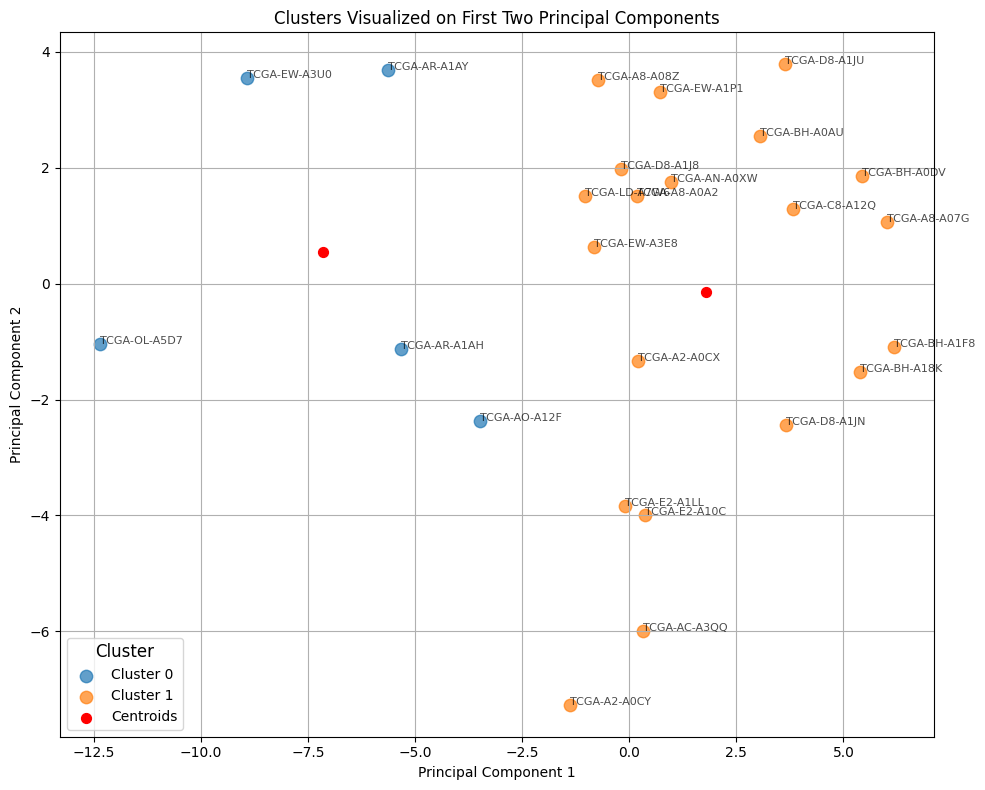

In [44]:
# 4. Visualize clusters using first two principal components
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_points = optimal_pca_df[optimal_pca_df['Cluster'] == cluster]
    plt.scatter(
        cluster_points['PC1'], 
        cluster_points['PC2'],
        label=f'Cluster {cluster}',
        alpha=0.7,
        s=80
    )
    for i, row in cluster_points.iterrows():
        plt.text(row['PC1'], row['PC2'], str(row['Patient ID']), fontsize=8, alpha=0.7)

centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0], 
    centers[:, 1], 
    s=200, 
    marker='.', 
    c='red', 
    label='Centroids'
)


plt.legend(title='Cluster', fontsize=10, title_fontsize=12, loc='lower left')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualized on First Two Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
optimal_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Patient ID,Cluster
0,3.647907,3.785523,1.336597,-0.208642,-2.173467,-0.159574,-0.201224,-0.175144,TCGA-D8-A1JU,1
1,0.321251,-5.989832,4.189945,-0.206970,0.171948,0.960831,-0.520194,1.106246,TCGA-AC-A3QQ,1
2,3.832310,1.285090,-0.477499,-2.193931,3.982175,-0.967499,-0.351455,0.389307,TCGA-C8-A12Q,1
3,-5.633592,3.690983,-3.478281,-0.803440,0.446135,0.610747,-2.052404,0.316239,TCGA-AR-A1AY,0
4,0.174023,1.517975,0.166070,2.912341,0.421168,-0.887175,-1.127990,-1.452414,TCGA-A8-A0A2,1


In [46]:
features_to_analyze = optimal_pca_df.columns.drop(['Patient ID', 'Cluster'])
features_to_analyze


Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], dtype='object')

In [47]:
cluster_stats = optimal_pca_df.groupby('Cluster')[['PC1', 'PC2', 'PC3']].agg(['mean', 'std', 'min', 'max'])

# --- 2. Display the results ---
print("Descriptive Statistics for Each Cluster:")
cluster_stats

# # Optional: Display mean values separately for clarity
# print("\nMean Feature Values for Each Cluster:")
# print(cluster_stats['mean'])


Descriptive Statistics for Each Cluster:


PC1                                      PC2            \
             mean       std        min       max      mean       std   
Cluster                                                                
0       -7.146377  3.511365 -12.364445 -3.486273  0.540322  2.858015   
1        1.786594  2.576969  -1.392214  6.184113 -0.135081  3.184319   

                                  PC3                                
              min       max      mean       std       min       max  
Cluster                                                              
0       -2.374040  3.690983 -1.291397  3.541766 -5.974913  2.826122  
1       -7.265999  3.785523  0.322849  1.991944 -3.150876  4.189945

In [48]:
optimal_pca.components_.shape

(8, 50)